In [268]:

import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

torch.Size([60000, 28, 28])
torch.Size([60000])


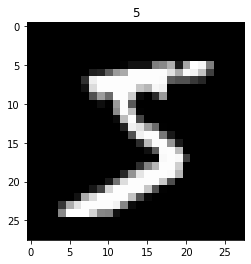

In [283]:
# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10              # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 250
LR = 0.001              # learning rate



train_data = torchvision.datasets.MNIST(
    root='./data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,
)

# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

#Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


datasets.MNIST.resources = [
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
]

trainset = datasets.MNIST(root='./data', train=True,download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=2000,shuffle=False, num_workers=2)
test_y = testset.test_labels


#test_data = torchvision.datasets.MNIST(root='./data', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
#test_y = test_data.test_labels


In [284]:
images, labels = next(iter(test_loader))
print (labels.shape)

torch.Size([2000])


In [271]:


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(320, 10)
        #self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #in_size = x.size(0)
        x =self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(in_size, -1)  # flatten the output of conv2 to (batch_size, 320)
        x = x.reshape(x.shape[0], -1)  
        #x = F.relu(self.fc1(x))
        out = self.fc1(x)
        return out,x    # return x for visualization

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=10, bias=True)
)
before training with accuracy tensor(0.0680)


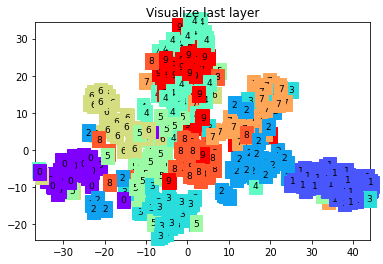

In [272]:

cnn = Net()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
from sklearn.manifold import TSNE;

def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()

#before training 
images, labelss = next(iter(test_loader))

test_output, last_layer = cnn(images)

pred_y = test_output.max(1)[1]
accuracy = (pred_y == labelss).sum()/ labelss.shape[0]
print('before training with accuracy',accuracy)
            
            # Visualization of trained flatten layer (T-SNE)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
labels = labelss.numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels)
#





shape of pca_reduced.shape =  (2000, 2)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


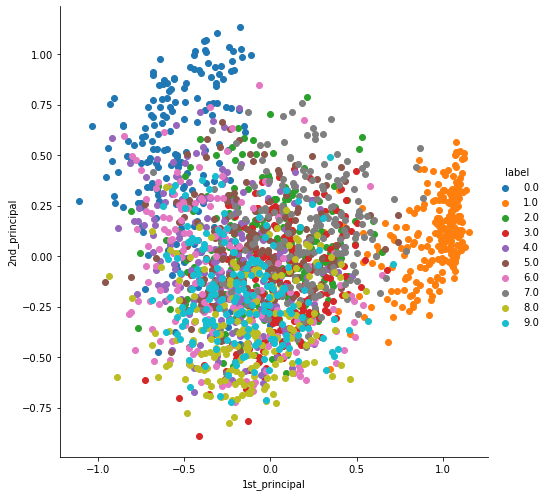

In [273]:
#PCA visualization 
from sklearn import decomposition
import pandas as pd
import seaborn as sn
pca = decomposition.PCA()

# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_data = pca.fit_transform(last_layer.data.numpy())
#print(last_layer.shape,labelss.shape,test_y.shape)
# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)


pca_data = np.vstack((pca_data.T,labelss)).T

# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", size=7).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()


In [274]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(last_layer.data.numpy())
print("Standardized dataset dimensions:" ,standardized_data.shape)


Standardized dataset dimensions: (2000, 320)


In [275]:
#Finding the co-variance matrix which is : A^T * A
sample_data = standardized_data

# matrix multiplication using numpy
covar_matrix = np.matmul(sample_data.T , sample_data)

print ( "The shape of variance matrix = ", covar_matrix.shape)

The shape of variance matrix =  (320, 320)


after training with accuracy tensor(0.9345)


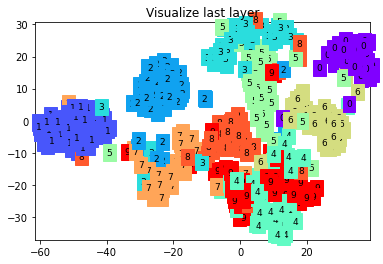

after training with accuracy tensor(0.9615)


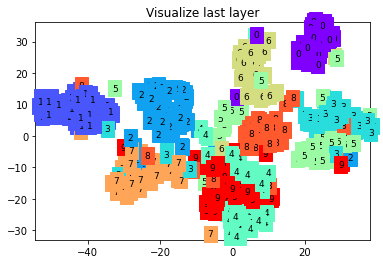

after training with accuracy tensor(0.9655)


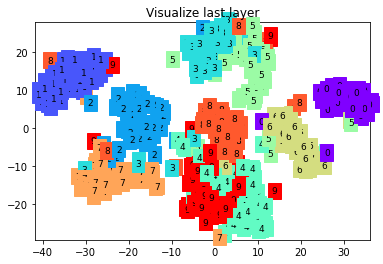

after training with accuracy tensor(0.9725)


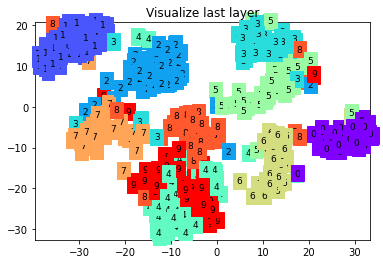

after training with accuracy tensor(0.9780)


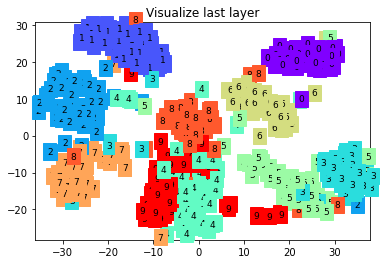

after training with accuracy tensor(0.9785)


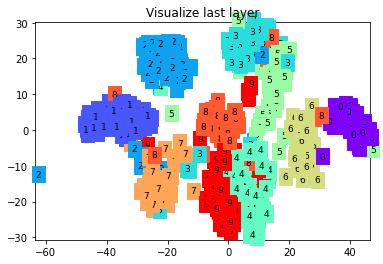

after training with accuracy tensor(0.9780)


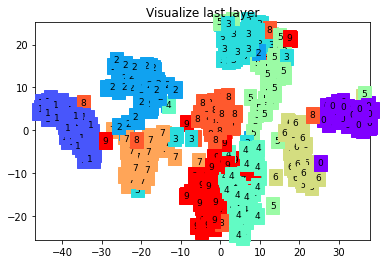

after training with accuracy tensor(0.9790)


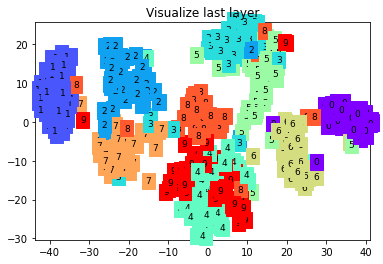

after training with accuracy tensor(0.9810)


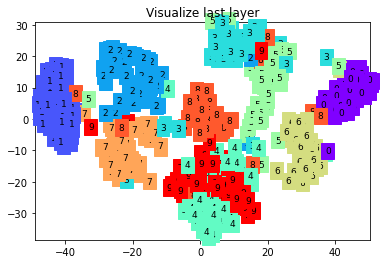

after training with accuracy tensor(0.9810)


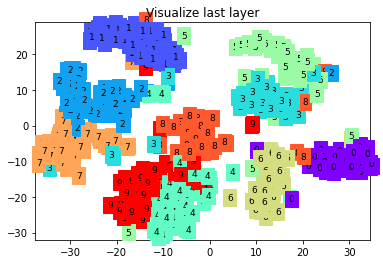

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [276]:
# training and testing
train_losses=[]
validation_losses=[]
for epoch in range(EPOCH):
    train_loss=0
    validation_loss=0
    
    cnn.train()
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward() # backpropagation, compute gradients
        optimizer.step()

        train_loss += loss.item()
    
    train_losses.append(train_loss/len(train_loader))
    
    cnn.eval() 
    
 
    images, labels = next(iter(test_loader))
    test_output, last_layer = cnn(images)
    val_loss = loss_func(test_output, labels)
    validation_loss += val_loss.item()
    
    pred_y = test_output.max(1)[1]
    accuracy = (pred_y == labels).sum()/ labels.shape[0]
    print('after training with accuracy',accuracy)
            
            # Visualization of trained flatten layer (T-SNE)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
    labelss = labels.numpy()[:plot_only]
    plot_with_labels(low_dim_embs, labelss)
    
    
    #pca.n_components = 2
    #pca_data = pca.fit_transform(last_layer.data.numpy())
#print(last_layer.shape,labelss.shape,test_y.shape)
# pca_reduced will contain the 2-d projects of simple data


    #pca_data = np.vstack((pca_data.T,labels.numpy())).T

    # creating a new data fram which help us in ploting the result data
    #pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
    #sn.FacetGrid(pca_df, hue="label", size=7).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    #plt.show()

plt.ioff()

# print 10 predictions from test data
images, labels = next(iter(test_loader))

test_output, _ = cnn(images[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(labels[:10].numpy(), 'real number')

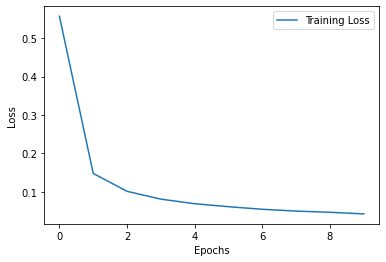

In [277]:

plt.plot(train_losses,label='Training Loss')  

plt.legend() 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show() 